In [4]:
import pandas as pd
df = pd.read_csv("ai4i2020.csv")
print(df.head())
print(df.info())


   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

In [6]:
import pandas as pd
df = pd.read_csv("ai4i2020.csv")
df_small = df.sample(n=2000, random_state=42)
print(df_small.shape)
df_small.to_csv("ai4i2020_small.csv", index=False)


(2000, 14)


LOADING DATA

Dataset shape: (2000, 14)

First few rows:
    UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0  6253     L53432    L                300.8                    310.3   
1  4685     M19544    M                303.6                    311.8   
2  1732     M16591    M                298.3                    307.9   
3  4743     L51922    L                303.3                    311.3   
4  4522     L51701    L                302.4                    310.4   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1538         36.1              198                0    0   
1                    1421         44.8              101                1    0   
2                    1485         42.0              117                0    0   
3                    1592         33.7               14                0    0   
4                    1865         23.9              129                0    0   

   HDF  PWF  OSF 

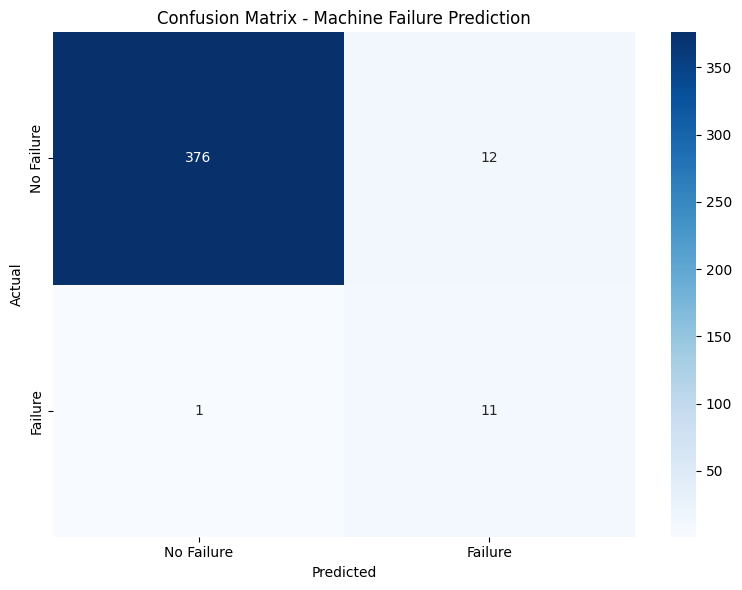

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# =============================================
# 1. LOAD AND EXPLORE DATA
# =============================================
print("="*60)
print("LOADING DATA")
print("="*60)

# Load your dataset
df = pd.read_csv('ai4i2020_small.csv')

print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nMissing values:")
print(df.isnull().sum())

print(f"\nMachine Failure distribution:")
print(df['Machine failure'].value_counts())

# =============================================
# 2. FEATURE ENGINEERING
# =============================================
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

# Select features for training
feature_cols = ['Air temperature [K]', 'Process temperature [K]', 
                'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Create additional engineered features for better performance
df['temp_diff'] = df['Process temperature [K]'] - df['Air temperature [K]']
df['power'] = df['Torque [Nm]'] * df['Rotational speed [rpm]'] / 1000  # Normalized
df['torque_speed_ratio'] = df['Torque [Nm]'] / (df['Rotational speed [rpm]'] + 1)

# Add engineered features to feature list
feature_cols.extend(['temp_diff', 'power', 'torque_speed_ratio'])

print(f"\nFeatures used for training: {feature_cols}")

# =============================================
# 3. PREPARE DATA FOR MACHINE FAILURE PREDICTION
# =============================================
print("\n" + "="*60)
print("PREPARING DATA FOR MACHINE FAILURE PREDICTION")
print("="*60)

X = df[feature_cols]
y_machine_failure = df['Machine failure']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_machine_failure, test_size=0.2, random_state=42, stratify=y_machine_failure
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Failure ratio in training: {y_train.sum() / len(y_train):.4f}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle imbalance with SMOTE
print("\nApplying SMOTE for class balancing...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE - Training set size: {X_train_resampled.shape[0]}")
print(f"After SMOTE - Failure ratio: {y_train_resampled.sum() / len(y_train_resampled):.4f}")

# =============================================
# 4. TRAIN MACHINE FAILURE MODEL
# =============================================
print("\n" + "="*60)
print("TRAINING MACHINE FAILURE PREDICTION MODEL")
print("="*60)

# Random Forest Model
print("\n[1] Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\n--- Random Forest Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['No Failure', 'Failure']))

# Gradient Boosting Model
print("\n[2] Training Gradient Boosting...")
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
gb_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_proba_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\n--- Gradient Boosting Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_gb):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_gb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=['No Failure', 'Failure']))

# =============================================
# 5. FEATURE IMPORTANCE
# =============================================
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop Features (Random Forest):")
print(feature_importance)

# =============================================
# 6. TRAIN FAILURE TYPE CLASSIFICATION MODELS
# =============================================
print("\n" + "="*60)
print("TRAINING FAILURE TYPE CLASSIFICATION MODELS")
print("="*60)

failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_models = {}
failure_results = {}

# Only train on samples where machine failure occurred
failure_indices = df[df['Machine failure'] == 1].index
X_failures = df.loc[failure_indices, feature_cols]
print(f"\nTotal failure samples: {len(X_failures)}")

for failure_type in failure_types:
    print(f"\n--- Training model for {failure_type} ---")
    
    y_failure = df.loc[failure_indices, failure_type]
    
    # Check if we have enough samples
    if y_failure.sum() < 5:
        print(f"Not enough samples for {failure_type} (only {y_failure.sum()}). Skipping...")
        continue
    
    # Split data
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(
        X_failures, y_failure, test_size=0.2, random_state=42, stratify=y_failure
    )
    
    # Scale
    X_f_train_scaled = scaler.transform(X_f_train)
    X_f_test_scaled = scaler.transform(X_f_test)
    
    # Apply SMOTE if needed
    if y_f_train.sum() > 1 and len(y_f_train) - y_f_train.sum() > 1:
        smote_f = SMOTE(random_state=42, k_neighbors=min(3, y_f_train.sum()-1))
        X_f_train_resampled, y_f_train_resampled = smote_f.fit_resample(
            X_f_train_scaled, y_f_train
        )
    else:
        X_f_train_resampled, y_f_train_resampled = X_f_train_scaled, y_f_train
    
    # Train model
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_f_train_resampled, y_f_train_resampled)
    
    # Predict and evaluate
    y_f_pred = model.predict(X_f_test_scaled)
    
    acc = accuracy_score(y_f_test, y_f_pred)
    f1 = f1_score(y_f_test, y_f_pred, zero_division=0)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Distribution in test: {y_f_test.value_counts().to_dict()}")
    
    failure_models[failure_type] = model
    failure_results[failure_type] = {'accuracy': acc, 'f1_score': f1}

# =============================================
# 7. SUMMARY OF ALL MODELS
# =============================================
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

print("\n--- Machine Failure Prediction (Best Model: Random Forest) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

print("\n--- Failure Type Classification Models ---")
for failure_type, results in failure_results.items():
    print(f"{failure_type}: Accuracy={results['accuracy']:.4f}, F1 Score={results['f1_score']:.4f}")

# =============================================
# 8. CONFUSION MATRIX VISUALIZATION
# =============================================
print("\n" + "="*60)
print("GENERATING CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Failure', 'Failure'],
            yticklabels=['No Failure', 'Failure'])
plt.title('Confusion Matrix - Machine Failure Prediction')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Confusion matrix saved as 'confusion_matrix.png'")

# =============================================
# 9. SAVE MODELS
# =============================================
print("\n" + "="*60)
print("SAVING MODELS")
print("="*60)

import pickle

# Save the best model and scaler
with open('machine_failure_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('failure_type_models.pkl', 'wb') as f:
    pickle.dump(failure_models, f)

print("Models saved successfully!")
print("- machine_failure_model.pkl")
print("- scaler.pkl")
print("- failure_type_models.pkl")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)